# Workflow for Geodata preparation for palmpy

Example: Winterthur.

Todo:

- split AV data into 
    - bb
    - pavementareas
    - gebäudefoots

for gebäudefoots: merge data somehow.

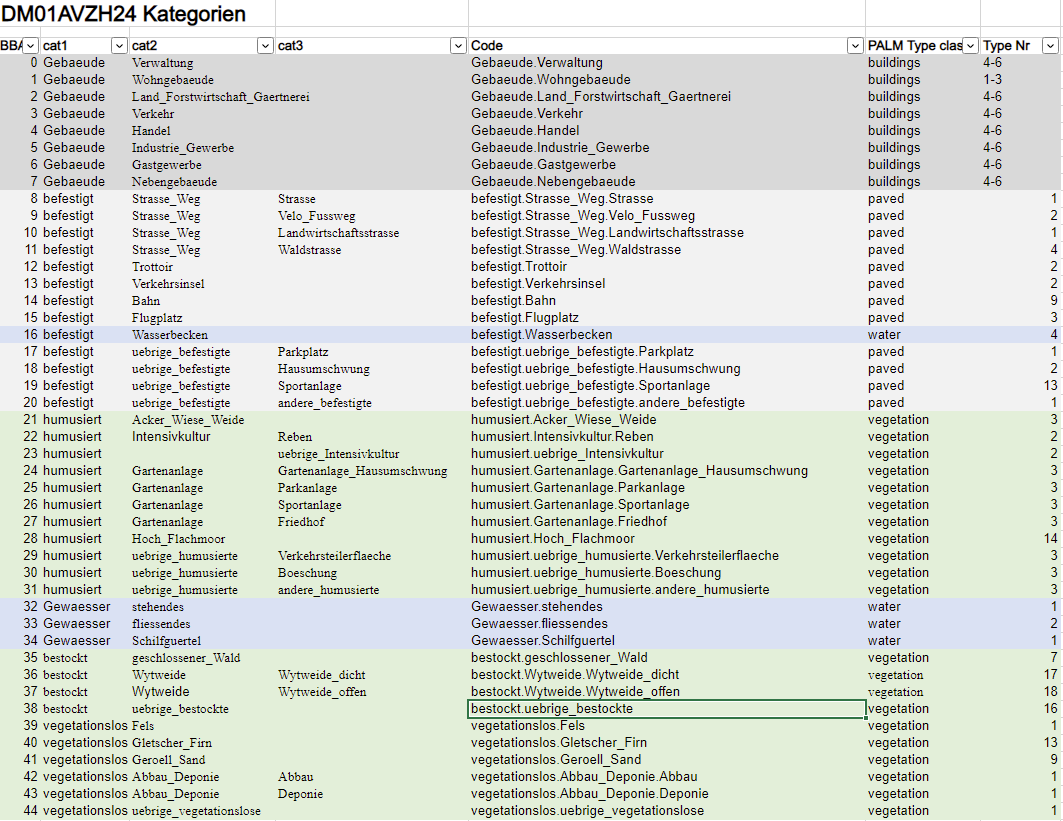

<hr>

In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

Import the AV dataset as shapefile.

In [4]:
gdf = gpd.read_file(r'E:\Geodaten\DWD_palmpy_tutorial\AV_Kanton_Zürich_DM01AVZH24_Bo_BoFlaeche_A_zuschnitt.shp') # if you have a huge dataset, define a bounding box with keyword bbox=(2689036,1255050,2705997,1268854)

Check if total bounds are reasonable. Here they match EPSG2056 or LV95 standards, and they are not NaN. So all good, yay.

In [5]:
gdf.total_bounds

array([2682736.379, 1246207.213, 2684212.81 , 1247871.038])

Have a sneek peek at the columns in it. ART and ART_TXT are what we look for as description of the surface.

In [6]:
gdf.columns

Index(['OBJID', 'ENTSTEHUNG', 'QUALITAET', 'QUALITAET_', 'ART', 'ART_TXT',
       'R1_OBJID', 'R1_NBIDENT', 'R1_IDENTIF', 'R1_BESCHRE', 'R1_GUELTIG',
       'R1_GUELTI1', 'R1_GUELTI2', 'R1_DATUM1', 'geometry'],
      dtype='object')

So which ART's are in there??

In [11]:
np.sort(gdf.ART.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 12, 13, 14, 16, 17, 18, 19,
       20, 24, 25, 26, 27, 29, 31, 32, 33, 38], dtype=int64)

What does that mean in text form?

In [12]:
np.sort(gdf.ART_TXT.unique())

array(['Gebaeude.Gastgewerbe', 'Gebaeude.Handel',
       'Gebaeude.Industrie_Gewerbe',
       'Gebaeude.Land_Forstwirtschaft_Gaertnerei',
       'Gebaeude.Nebengebaeude', 'Gebaeude.Verkehr',
       'Gebaeude.Verwaltung', 'Gebaeude.Wohngebaeude',
       'Gewaesser.fliessendes', 'Gewaesser.stehendes', 'befestigt.Bahn',
       'befestigt.Strasse_Weg.Strasse',
       'befestigt.Strasse_Weg.Velo_Fussweg', 'befestigt.Trottoir',
       'befestigt.Verkehrsinsel', 'befestigt.Wasserbecken',
       'befestigt.uebrige_befestigte.Hausumschwung',
       'befestigt.uebrige_befestigte.Parkplatz',
       'befestigt.uebrige_befestigte.Sportanlage',
       'befestigt.uebrige_befestigte.andere_befestigte',
       'bestockt.uebrige_bestockte', 'humusiert.Gartenanlage.Friedhof',
       'humusiert.Gartenanlage.Gartenanlage_Hausumschwung',
       'humusiert.Gartenanlage.Parkanlage',
       'humusiert.Gartenanlage.Sportanlage',
       'humusiert.uebrige_humusierte.Verkehrsteilerflaeche',
       'humusiert.uebr

So: we can split them now based on the table on top into everything we need: Building types, BB (Bodenbedeckung) types and pavement types.

In [18]:
bldg_types = [0,1,2,3,4,5,6,7]
bb_types = [16,21,22,23,24,25,26,27,28,29,30,31,35,36,37,38,39,40,41,42,43,44,32,33,34]
pav_types = [8,9,10,11,12,13,14,15,17,18,19,20]

Seperate into different dataframes

In [19]:
bldgs = gdf[gdf.ART.isin(bldg_types)]
bb = gdf[gdf.ART.isin(bb_types)]
pav = gdf[gdf.ART.isin(pav_types)]

Plot them to see if we did well:

<AxesSubplot:>

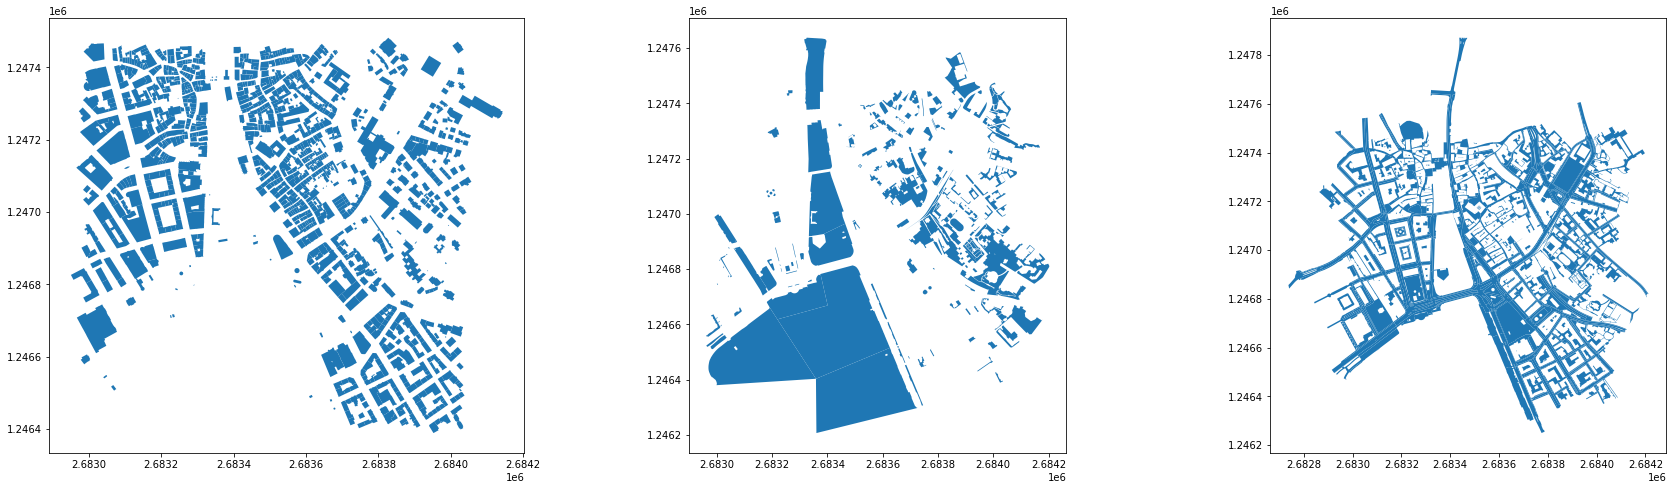

In [20]:
fig,ax = plt.subplots(1,3, figsize=(30,8))
bldgs.plot(ax=ax[0])
bb.plot(ax=ax[1])
pav.plot(ax=ax[2])

Do you need a popup to zoom around in? use qt:

In [21]:
#%matplotlib qt

plot buildings only to look at them

<AxesSubplot:>

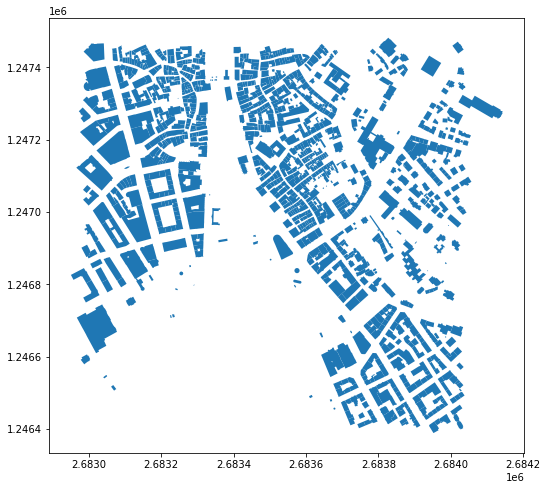

In [22]:
bldgs.plot()

Rename ART to BELAGSART in the pavement file and in the bb filte to OBJEKTART. It has been a requirement in palmpy, not any more, but I am doing it for backwards compatibility now.

In [23]:
pav = pav.rename(columns={'ART':'BELAGSART'})

In [24]:
bb = bb.rename(columns={'ART':'OBJEKTART'})

Set CRS to LV95 - the coordinates are in this coordinate system, but it just has not been set yet. With this, you declare the coordinates are in LV95. If you write WGS84, it won't complain, but it'll be wrong! You have to know the source CRS here.

In [28]:
pav.crs = {'init' :'epsg:2056'}
bldgs.crs = {'init' :'epsg:2056'}
bb.crs = {'init' :'epsg:2056'}

Tip: some geometries may be not closed, self intersecting, etc. You can solve that by creating a 0 distance buffer - which will basically rewrite the geometry into something valid.

In [29]:
bb.geometry = bb.geometry.buffer(0)
bldgs.geometry = bldgs.geometry.buffer(0)
pav.geometry = pav.geometry.buffer(0)

Save it!

In [27]:
pav.to_file('E:\Geodaten\DWD_palmpy_tutorial\processed\dwd_tutorial_paved_surfaces.shp')
bldgs.to_file('E:\Geodaten\DWD_palmpy_tutorial\processed\dwd_tutorial_building_surfaces.shp')
bb.to_file('E:\Geodaten\DWD_palmpy_tutorial\processed\dwd_tutorial_vegetation_surfaces.shp')

In [16]:
bldgs

,OBJID,ENTSTEHUNG,QUALITAET,QUALITAET_,ART,ART_TXT,R1_OBJID,R1_NBIDENT,R1_IDENTIF,R1_BESCHRE,R1_GUELTIG,R1_GUELTI1,R1_GUELTI2,R1_DATUM1,geometry
19,5432,BBNachfuehrung[185],0,AV93,7,Gebaeude.Nebengebaeude,185,ZH0200000176,961,BÄ Raststätte Kemptthal,1,gueltig,20190813,-99,"POLYGON ((2695219.693 1256450.755, 2695217.459..."
67,5378,BBNachfuehrung[183],0,AV93,2,Gebaeude.Land_Forstwirtschaft_Gaertnerei,183,ZH0200000176,960.01,Kleinikon 5,1,gueltig,20190524,-99,"POLYGON ((2693982.757 1257009.918, 2693981.319..."
68,5377,BBNachfuehrung[183],0,AV93,7,Gebaeude.Nebengebaeude,183,ZH0200000176,960.01,Kleinikon 5,1,gueltig,20190524,-99,"POLYGON ((2693996.236 1257005.530, 2693999.292..."
71,5368,BBNachfuehrung[174],0,AV93,5,Gebaeude.Industrie_Gewerbe,174,ZH0200000176,952.08,Trafo Rastplatz Kemptthal,1,gueltig,20190214,-99,"POLYGON ((2695138.895 1256174.459, 2695136.170..."
74,5363,BBNachfuehrung[171],0,AV93,7,Gebaeude.Nebengebaeude,171,ZH0200000176,956,Neubau Agrovet,1,gueltig,20190423,-99,"POLYGON ((2693724.845 1256015.429, 2693724.604..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123868,711,BBNachfuehrung[14],0,AV93,7,Gebaeude.Nebengebaeude,14,ZH0200000065,Oberembrach,Oberembrach,1,gueltig,20070411,-99,"POLYGON ((2690076.405 1261789.385, 2690079.373..."
123874,610,BBNachfuehrung[14],0,AV93,2,Gebaeude.Land_Forstwirtschaft_Gaertnerei,14,ZH0200000065,Oberembrach,Oberembrach,1,gueltig,20070411,-99,"POLYGON ((2690652.656 1261498.919, 2690646.330..."
123875,608,BBNachfuehrung[14],0,AV93,2,Gebaeude.Land_Forstwirtschaft_Gaertnerei,14,ZH0200000065,Oberembrach,Oberembrach,1,gueltig,20070411,-99,"POLYGON ((2690656.115 1261493.306, 2690657.135..."
123876,603,BBNachfuehrung[14],0,AV93,1,Gebaeude.Wohngebaeude,14,ZH0200000065,Oberembrach,Oberembrach,1,gueltig,20070411,-99,"POLYGON ((2690653.163 1261525.606, 2690645.004..."


<hr>

## Process the Buildings

The buildings dataset does not contain height in the AV dataset. But we have the LoD1 dataset.

In [31]:
bld = gpd.read_file(r'E:\Geodaten\DWD_palmpy_tutorial\lod1_gebaeude_max_3d_kantonzuerich_zuschnitt.shp') 

In [35]:
bld.columns

Index(['adat', 'art', 'ausr', 'bem', 'dach', 'edat', 'egid', 'filt', 'gid_3d',
       'h_boden', 'h_trauf', 'h_first', 'h_mean', 'h_rel_trau', 'h_rel_firs',
       'h_rel_mean', 'ogid', 'otype', 'qumess', 'sta', 'wichtig', 'geometry'],
      dtype='object')

Plot it by height column (mean).

<AxesSubplot:>

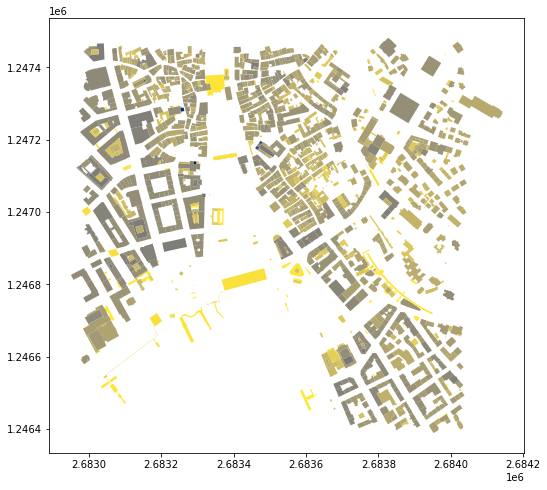

In [42]:
bld.plot(column='h_rel_mean', cmap='cividis_r')

According to the palmpy documentation, you'll need a few attirbutes: HEIGHT_TOP, HEIGHT_BOT, ID, BLDGTYP. The first three are easy - the BLDGTYP requires some work.
Is year in the bld dataset?

In [45]:
bld

,adat,art,ausr,bem,dach,edat,egid,filt,gid_3d,h_boden,...,h_mean,h_rel_trau,h_rel_firs,h_rel_mean,ogid,otype,qumess,sta,wichtig,geometry
0,20140925,0,BATCHUSER,OK,NaN,20090101,140856.0,08,z41ac39cc00001bb0-00-0001,404.8,...,424.95,16.6,23.7,20.15,z41ac39cc00001bb0,BB,None,real,None,"POLYGON ((2683326.581 1247163.424, 2683326.252..."
1,20140925,1,BATCHUSER,OK,NaN,20090101,140848.0,08,z41ac39cc00001bb3-00-0001,404.9,...,422.85,16.1,19.8,17.95,z41ac39cc00001bb3,BB,None,real,None,"POLYGON ((2683315.731 1247196.243, 2683308.974..."
2,20140925,7,BATCHUSER,OK,NaN,20090101,302040085.0,08,z41ac39cc0000196e-00-0001,405.1,...,419.90,13.2,16.4,14.80,z41ac39cc0000196e,BB,None,real,None,"POLYGON ((2683442.768 1247237.870, 2683435.881..."
3,20140925,7,BATCHUSER,OK,NaN,20090101,302020715.0,08,z41ac39cc00001970-00-0001,413.6,...,424.20,10.6,10.6,10.60,z41ac39cc00001970,BB,None,real,None,"POLYGON ((2683559.524 1247128.937, 2683554.815..."
4,20140925,1,BATCHUSER,OK,NaN,20090101,140498.0,08,z41ac39cc00001972-00-0001,425.1,...,433.25,6.3,10.0,8.15,z41ac39cc00001972,BB,None,real,None,"POLYGON ((2683664.574 1247086.001, 2683657.552..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,20210720,0,GEORUR,OK,3000.0,20110819,9011091.0,08,z41ac69e900023244-00-0002,404.7,...,430.10,24.0,26.8,25.40,z41ac69e900023244,BB,None,real,None,"POLYGON ((2682998.683 1246690.120, 2682988.509..."
1472,20210720,0,GEORUR,OK,6000.0,20110819,9011091.0,08,z41ac69e900023244-00-0004,404.7,...,423.20,18.5,18.5,18.50,z41ac69e900023244,BB,None,real,None,"POLYGON ((2682995.775 1246712.435, 2682994.005..."
1473,20220215,8,BATCHUSER,OKMESS,NaN,20121005,NaN,08,z41ac437000005e7c-01-0001,406.8,...,408.80,2.0,2.0,2.00,z41ac437000005e7c,EO,None,real,None,"POLYGON ((2683006.534 1247000.477, 2683004.690..."
1474,20210720,3,GEORUR,OKMESS,6000.0,20210720,9011091.0,08,z55c9d3b4aef3002f-00-0001,419.6,...,419.90,0.3,0.3,0.30,z55c9d3b4aef3002f,EO,None,real,None,"POLYGON ((2683031.163 1246613.674, 2683020.865..."


No. is it in the AV dataset?

In [48]:
bldgs

,OBJID,ENTSTEHUNG,QUALITAET,QUALITAET_,ART,ART_TXT,R1_OBJID,R1_NBIDENT,R1_IDENTIF,R1_BESCHRE,R1_GUELTIG,R1_GUELTI1,R1_GUELTI2,R1_DATUM1,geometry
63,99784,BBNachfuehrung[8219],0,AV93,4,Gebaeude.Handel,8219,ZH0200000261,30036,"Sechseläuten, Bellevueplatz",1,gueltig,20171025,-99,"POLYGON ((2683570.035 1246791.096, 2683566.504..."
102,49286,BBNachfuehrung[9300],0,AV93,0,Gebaeude.Verwaltung,9300,ZH0200000261,32715,Umnummerierung GVZ-Nummern,1,gueltig,20200112,-99,"POLYGON ((2684027.769 1246655.516, 2684020.250..."
136,95228,BBNachfuehrung[9300],0,AV93,1,Gebaeude.Wohngebaeude,9300,ZH0200000261,32715,Umnummerierung GVZ-Nummern,1,gueltig,20200112,-99,"POLYGON ((2684003.160 1246655.412, 2684015.278..."
138,96243,BBNachfuehrung[6896],0,AV93,7,Gebaeude.Nebengebaeude,6896,ZH0200000261,29524,"Kreuzbühlstrasse 16, 20, 26",1,gueltig,20160708,-99,"POLYGON ((2683986.611 1246652.465, 2683985.440..."
140,95229,BBNachfuehrung[9300],0,AV93,1,Gebaeude.Wohngebaeude,9300,ZH0200000261,32715,Umnummerierung GVZ-Nummern,1,gueltig,20200112,-99,"POLYGON ((2684031.197 1246614.074, 2684018.828..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,683,BBNachfuehrung[9300],0,AV93,1,Gebaeude.Wohngebaeude,9300,ZH0200000261,32715,Umnummerierung GVZ-Nummern,1,gueltig,20200112,-99,"POLYGON ((2683706.805 1247140.648, 2683706.679..."
2089,540,BBNachfuehrung[84],0,AV93,7,Gebaeude.Nebengebaeude,84,ZH0200000261,AA3106,AV93 Aufarbeitung,1,gueltig,20011231,-99,"POLYGON ((2683647.084 1247289.674, 2683643.669..."
2090,536,BBNachfuehrung[84],0,AV93,7,Gebaeude.Nebengebaeude,84,ZH0200000261,AA3106,AV93 Aufarbeitung,1,gueltig,20011231,-99,"POLYGON ((2683534.182 1247321.479, 2683533.506..."
2091,1840,BBNachfuehrung[84],0,AV93,7,Gebaeude.Nebengebaeude,84,ZH0200000261,AA3106,AV93 Aufarbeitung,1,gueltig,20011231,-99,"POLYGON ((2683633.134 1247297.933, 2683630.110..."


## Create the real buildings shapefile

Masterplan: 

Use AV data from below outside of Gemeinde bounds.  
Add the building_block_best_zukunft dataset as main source for building height. Use Baujahr and usage type to create building_type. **PROBLEM: many bldgs have stockwerke=0, so hoehe=3!!!**  
add ab_geb_nicht_3d buildings to it. check for buildings on top of each other.  
add rp_prognostizierte_gebaeude  
add av_geb_proj, which are not unterirdisch, otherwise it's stupid.

In [30]:
bldgs

,OBJID,ENTSTEHUNG,QUALITAET,QUALITAET_,ART,ART_TXT,R1_OBJID,R1_NBIDENT,R1_IDENTIF,R1_BESCHRE,R1_GUELTIG,R1_GUELTI1,R1_GUELTI2,R1_DATUM1,geometry
63,99784,BBNachfuehrung[8219],0,AV93,4,Gebaeude.Handel,8219,ZH0200000261,30036,"Sechseläuten, Bellevueplatz",1,gueltig,20171025,-99,"POLYGON ((2683570.035 1246791.096, 2683566.504..."
102,49286,BBNachfuehrung[9300],0,AV93,0,Gebaeude.Verwaltung,9300,ZH0200000261,32715,Umnummerierung GVZ-Nummern,1,gueltig,20200112,-99,"POLYGON ((2684027.769 1246655.516, 2684020.250..."
136,95228,BBNachfuehrung[9300],0,AV93,1,Gebaeude.Wohngebaeude,9300,ZH0200000261,32715,Umnummerierung GVZ-Nummern,1,gueltig,20200112,-99,"POLYGON ((2684003.160 1246655.412, 2684015.278..."
138,96243,BBNachfuehrung[6896],0,AV93,7,Gebaeude.Nebengebaeude,6896,ZH0200000261,29524,"Kreuzbühlstrasse 16, 20, 26",1,gueltig,20160708,-99,"POLYGON ((2683986.611 1246652.465, 2683985.440..."
140,95229,BBNachfuehrung[9300],0,AV93,1,Gebaeude.Wohngebaeude,9300,ZH0200000261,32715,Umnummerierung GVZ-Nummern,1,gueltig,20200112,-99,"POLYGON ((2684031.197 1246614.074, 2684018.828..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,683,BBNachfuehrung[9300],0,AV93,1,Gebaeude.Wohngebaeude,9300,ZH0200000261,32715,Umnummerierung GVZ-Nummern,1,gueltig,20200112,-99,"POLYGON ((2683706.805 1247140.648, 2683706.679..."
2089,540,BBNachfuehrung[84],0,AV93,7,Gebaeude.Nebengebaeude,84,ZH0200000261,AA3106,AV93 Aufarbeitung,1,gueltig,20011231,-99,"POLYGON ((2683647.084 1247289.674, 2683643.669..."
2090,536,BBNachfuehrung[84],0,AV93,7,Gebaeude.Nebengebaeude,84,ZH0200000261,AA3106,AV93 Aufarbeitung,1,gueltig,20011231,-99,"POLYGON ((2683534.182 1247321.479, 2683533.506..."
2091,1840,BBNachfuehrung[84],0,AV93,7,Gebaeude.Nebengebaeude,84,ZH0200000261,AA3106,AV93 Aufarbeitung,1,gueltig,20011231,-99,"POLYGON ((2683633.134 1247297.933, 2683630.110..."


### create surrounding buildings from AV data

In [18]:
gemeindegrenzen = gpd.read_file(r'K:\Geodaten\KTZH_AV_2021\Amtliche_Vermessung_-_Datenmode...nton_Zurich_-DM01AVZH24-_-OGD\Ge_Gemeindegrenze_A.shp')

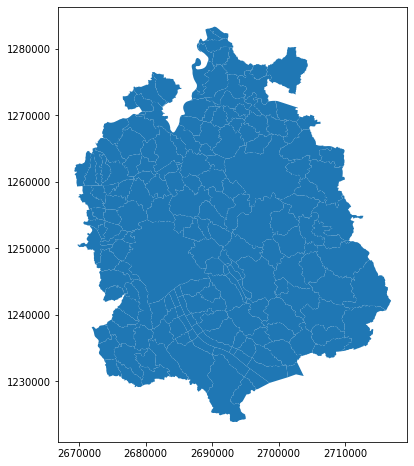

In [67]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,8)
gemeindegrenzen.plot()

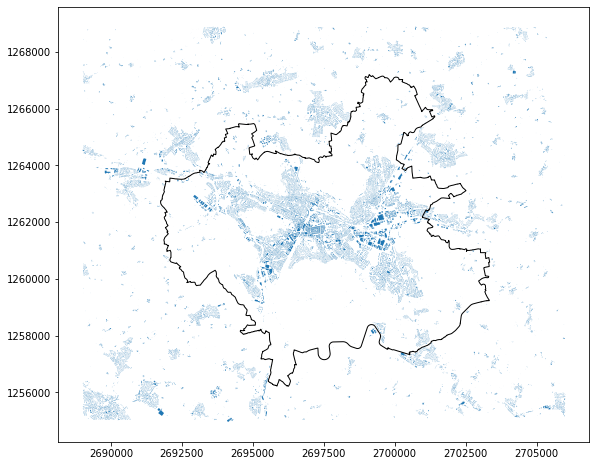

In [20]:
wintigrenze = gemeindegrenzen[gemeindegrenzen.R2_NAME == 'Winterthur']
ax = plt.figure().gca()
bldgs.plot(ax=ax)
wintigrenze.plot(color='None', linewidth=1, edgecolor='black', ax=ax)

make a guetsli-cutout of the buildings dataset with shape of winterthur. It's as easy as baking cookies.

In [21]:
bldg_outer = gpd.overlay(bldgs, wintigrenze, how='difference')

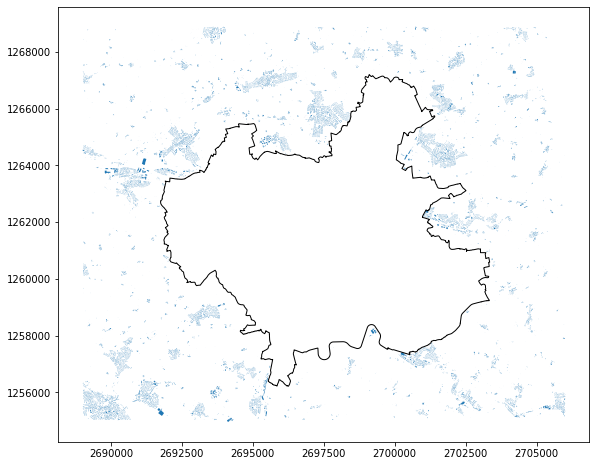

In [22]:
ax = plt.figure().gca()
bldg_outer.plot(ax=ax)
wintigrenze.plot(color='None', linewidth=1, edgecolor='black', ax=ax)

THe amout of buildings was cut in half. 

In [23]:
outpath = r"K:\Geodaten\WinLab"
print(len(bldgs),len(bldg_outer))

47032 24940


In [24]:
bldg_outer

,OBJID,ENTSTEHUNG,QUALITAET,QUALITAET_,ART,ART_TXT,R1_OBJID,R1_NBIDENT,R1_IDENTIF,R1_BESCHRE,R1_GUELTIG,R1_GUELTI1,R1_GUELTI2,R1_DATUM1,geometry
19,5432,BBNachfuehrung[185],0,AV93,7,Gebaeude.Nebengebaeude,185,ZH0200000176,961,BÄ Raststätte Kemptthal,1,gueltig,20190813,-99,"POLYGON ((2695219.693 1256450.755, 2695217.459..."
67,5378,BBNachfuehrung[183],0,AV93,2,Gebaeude.Land_Forstwirtschaft_Gaertnerei,183,ZH0200000176,960.01,Kleinikon 5,1,gueltig,20190524,-99,"POLYGON ((2693982.757 1257009.918, 2693981.319..."
68,5377,BBNachfuehrung[183],0,AV93,7,Gebaeude.Nebengebaeude,183,ZH0200000176,960.01,Kleinikon 5,1,gueltig,20190524,-99,"POLYGON ((2693996.236 1257005.530, 2693999.292..."
71,5368,BBNachfuehrung[174],0,AV93,5,Gebaeude.Industrie_Gewerbe,174,ZH0200000176,952.08,Trafo Rastplatz Kemptthal,1,gueltig,20190214,-99,"POLYGON ((2695138.895 1256174.459, 2695136.170..."
74,5363,BBNachfuehrung[171],0,AV93,7,Gebaeude.Nebengebaeude,171,ZH0200000176,956,Neubau Agrovet,1,gueltig,20190423,-99,"POLYGON ((2693724.845 1256015.429, 2693724.604..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123868,711,BBNachfuehrung[14],0,AV93,7,Gebaeude.Nebengebaeude,14,ZH0200000065,Oberembrach,Oberembrach,1,gueltig,20070411,-99,"POLYGON ((2690076.405 1261789.385, 2690079.373..."
123874,610,BBNachfuehrung[14],0,AV93,2,Gebaeude.Land_Forstwirtschaft_Gaertnerei,14,ZH0200000065,Oberembrach,Oberembrach,1,gueltig,20070411,-99,"POLYGON ((2690652.656 1261498.919, 2690646.330..."
123875,608,BBNachfuehrung[14],0,AV93,2,Gebaeude.Land_Forstwirtschaft_Gaertnerei,14,ZH0200000065,Oberembrach,Oberembrach,1,gueltig,20070411,-99,"POLYGON ((2690656.115 1261493.306, 2690657.135..."
123876,603,BBNachfuehrung[14],0,AV93,1,Gebaeude.Wohngebaeude,14,ZH0200000065,Oberembrach,Oberembrach,1,gueltig,20070411,-99,"POLYGON ((2690653.163 1261525.606, 2690645.004..."


In [25]:
bldg_outer['HEIGHT_TOP'] = 8
bldg_outer['HEIGHT_BOT'] = 0
bldg_outer['ID'] = bldg_outer.index
bldg_outer['BLDGTYP'] = 2 #residential, 1950-2000
bldg_outer

,OBJID,ENTSTEHUNG,QUALITAET,QUALITAET_,ART,ART_TXT,R1_OBJID,R1_NBIDENT,R1_IDENTIF,R1_BESCHRE,R1_GUELTIG,R1_GUELTI1,R1_GUELTI2,R1_DATUM1,geometry,HEIGHT_TOP,HEIGHT_BOT,ID,BLDGTYP
19,5432,BBNachfuehrung[185],0,AV93,7,Gebaeude.Nebengebaeude,185,ZH0200000176,961,BÄ Raststätte Kemptthal,1,gueltig,20190813,-99,"POLYGON ((2695219.693 1256450.755, 2695217.459...",8,0,19,2
67,5378,BBNachfuehrung[183],0,AV93,2,Gebaeude.Land_Forstwirtschaft_Gaertnerei,183,ZH0200000176,960.01,Kleinikon 5,1,gueltig,20190524,-99,"POLYGON ((2693982.757 1257009.918, 2693981.319...",8,0,67,2
68,5377,BBNachfuehrung[183],0,AV93,7,Gebaeude.Nebengebaeude,183,ZH0200000176,960.01,Kleinikon 5,1,gueltig,20190524,-99,"POLYGON ((2693996.236 1257005.530, 2693999.292...",8,0,68,2
71,5368,BBNachfuehrung[174],0,AV93,5,Gebaeude.Industrie_Gewerbe,174,ZH0200000176,952.08,Trafo Rastplatz Kemptthal,1,gueltig,20190214,-99,"POLYGON ((2695138.895 1256174.459, 2695136.170...",8,0,71,2
74,5363,BBNachfuehrung[171],0,AV93,7,Gebaeude.Nebengebaeude,171,ZH0200000176,956,Neubau Agrovet,1,gueltig,20190423,-99,"POLYGON ((2693724.845 1256015.429, 2693724.604...",8,0,74,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123868,711,BBNachfuehrung[14],0,AV93,7,Gebaeude.Nebengebaeude,14,ZH0200000065,Oberembrach,Oberembrach,1,gueltig,20070411,-99,"POLYGON ((2690076.405 1261789.385, 2690079.373...",8,0,123868,2
123874,610,BBNachfuehrung[14],0,AV93,2,Gebaeude.Land_Forstwirtschaft_Gaertnerei,14,ZH0200000065,Oberembrach,Oberembrach,1,gueltig,20070411,-99,"POLYGON ((2690652.656 1261498.919, 2690646.330...",8,0,123874,2
123875,608,BBNachfuehrung[14],0,AV93,2,Gebaeude.Land_Forstwirtschaft_Gaertnerei,14,ZH0200000065,Oberembrach,Oberembrach,1,gueltig,20070411,-99,"POLYGON ((2690656.115 1261493.306, 2690657.135...",8,0,123875,2
123876,603,BBNachfuehrung[14],0,AV93,1,Gebaeude.Wohngebaeude,14,ZH0200000065,Oberembrach,Oberembrach,1,gueltig,20070411,-99,"POLYGON ((2690653.163 1261525.606, 2690645.004...",8,0,123876,2


is an id used twice? -> No, good.

In [26]:
bldg_outer.ID.duplicated().sum()

0

In [27]:
#bldg_outer.to_file(outpath+r'\buildings\buildings_outside_winti.shp')

<hr>

### building heights in winterthurer gemeinde

building_block_best_zukunft -> LoD1_Hoehe  
av_gebaeude_nicht_3d -> hoehe  
rp_prognostizierte_gebaeude -> gebaeudeho  
av_gebaeude_proj -> Hoehe  


In [69]:
#bbbz = gpd.read_file(r'K:\Geodaten\WinLab\220408_Datenlieferung_zhaw\211102_Datenlieferung_geonet\building_block_best_zukunft.shp')
bbbz = gpd.read_file(r'K:\Geodaten\WinLab\220408_Datenlieferung_zhaw\211102_Datenlieferung_geonet\building_block_best_zukunft_singleparts_light.shp')
agn3 = gpd.read_file(r'K:\Geodaten\WinLab\220408_Datenlieferung_zhaw\211102_Datenlieferung_geonet\av_gebaeude_nicht_3D.shp')
rpg = gpd.read_file(r'K:\Geodaten\WinLab\220408_Datenlieferung_zhaw\220225_Prognostizierte_Gebaeude\rp_prognostizierte_gebaeude.shp')
agp = gpd.read_file(r'K:\Geodaten\WinLab\220408_Datenlieferung_zhaw\211102_Datenlieferung_geonet\av_gebaeude_proj.shp')

B_Lod1_hoe und LoD1_Hoehe sind gleich:

In [71]:
#len(bbbz) - (bbbz.LoD1_Hoehe == bbbz.B_Lod1_Hoe).sum()

In [77]:
bbbz.Objekttyp.unique()

array(['NebengebÃ¤ude', 'WohngebÃ¤ude', 'Land-, ForstwirtschaftsgebÃ¤ude',
       'Unterstand_Ueberdachung', 'VerwaltungsgebÃ¤ude',
       'IndustriegebÃ¤ude', 'HandelsgebÃ¤ude', None, 'VerkehrsgebÃ¤ude',
       'Silo_Turm_Gasometer', 'GastgewerbegebÃ¤ude', 'Hochkamin',
       'Land-, Forstwirtschaftsg*'], dtype=object)

In [78]:
bbbz['HEIGHT_TOP'] = bbbz.LoD1_Hoehe
bbbz['HEIGHT_BOT'] = 0
bbbz['ID'] = bbbz.index
bbbz['BLDGTYP'] = 999

In [32]:
bbbz.loc[(bbbz.Objekttyp == 'Wohngebäude') & (bbbz.baujahr < 1950), "BLDGTYP"] = 1
bbbz.loc[(bbbz.Objekttyp == 'Wohngebäude') & (bbbz.baujahr >= 1950) & (bbbz.baujahr < 2000), "BLDGTYP"] = 2
bbbz.loc[(bbbz.Objekttyp == 'Wohngebäude') & (bbbz.baujahr >= 2000), "BLDGTYP"] = 3
bbbz.loc[(bbbz.Objekttyp != 'Wohngebäude') & (bbbz.baujahr < 1950), "BLDGTYP"] = 4
bbbz.loc[(bbbz.Objekttyp != 'Wohngebäude') & (bbbz.baujahr >= 1950) & (bbbz.baujahr < 2000), "BLDGTYP"] = 5
bbbz.loc[(bbbz.Objekttyp != 'Wohngebäude') & (bbbz.baujahr >= 2000), "BLDGTYP"] = 6

In [86]:
def classify_bldgtyp(gdf, name_typecol = 'Objekttyp', name_jahrcol = 'baujahr', name_wohngebaeude = 'WohngebÃ¤ude'):
    gdf.loc[(gdf[name_typecol] == name_wohngebaeude) & (gdf[name_jahrcol] < 1950), "BLDGTYP"] = 1
    gdf.loc[(gdf[name_typecol] == name_wohngebaeude) & (gdf[name_jahrcol] >= 1950) & (gdf[name_jahrcol] < 2000), "BLDGTYP"] = 2
    gdf.loc[(gdf[name_typecol] == name_wohngebaeude) & (gdf[name_jahrcol] >= 2000), "BLDGTYP"] = 3
    gdf.loc[(gdf[name_typecol] != name_wohngebaeude) & (gdf[name_jahrcol] < 1950), "BLDGTYP"] = 4
    gdf.loc[(gdf[name_typecol] != name_wohngebaeude) & (gdf[name_jahrcol] >= 1950) & (gdf[name_jahrcol] < 2000), "BLDGTYP"] = 5
    gdf.loc[(gdf[name_typecol] != name_wohngebaeude) & (gdf[name_jahrcol] >= 2000), "BLDGTYP"] = 6
    return gdf

In [87]:
bbbz = classify_bldgtyp(bbbz)

In [88]:
print(bbbz.loc[0,'geometry'])

POLYGON ((2700291.480000097 1266070.060994302, 2700292.458000097 1266070.564994304, 2700295.814000097 1266072.293994303, 2700297.777000097 1266073.304994302, 2700303.754000097 1266061.703994303, 2700301.912000097 1266060.754994302, 2700299.956000097 1266059.746994302, 2700295.743000097 1266067.925994303, 2700294.257000097 1266067.159994299, 2700293.247000097 1266066.639994302, 2700291.480000097 1266070.060994302))


In [89]:
np.sort(bbbz.BLDGTYP.unique())

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [36]:
bbbz.head()

,gml_id,gml_parent,citygml_ta,citygml_fe,citygml_cr,Beschreibu,Dachflaech,Datum_Erst,EGID,Firsthoehe,...,bemerkung,bemerk,bem,GEBNR,geb_kontr,geometry,HEIGHT_TOP,HEIGHT_BOT,ID,BLDGTYP
0,_12458,fme-gen-dae6e156-44f9-41b5-b9e8-d11b6a54cd24,http://www.opengis.net/citygml/building/1.0,groupMember,0.0,Schopf,66.571230,None,201036368,4.481,...,None,None,None,12458,None,MULTIPOLYGON Z (((2700291.480 1266070.061 491....,4.481,0,0,4
1,_12452,fme-gen-dae6e156-44f9-41b5-b9e8-d11b6a54cd24,http://www.opengis.net/citygml/building/1.0,groupMember,0.0,Wohnhaus mit Schopf,249.505279,None,1155351,7.135,...,None,None,None,12452,None,MULTIPOLYGON Z (((2700324.419 1266113.163 493....,7.135,0,1,1
2,_12463,fme-gen-dae6e156-44f9-41b5-b9e8-d11b6a54cd24,http://www.opengis.net/citygml/building/1.0,groupMember,0.0,Garagengebäude,32.197351,None,201034501,3.311,...,None,None,None,12463,None,MULTIPOLYGON Z (((2700374.420 1266088.369 488....,3.311,0,2,5
3,_12455,fme-gen-dae6e156-44f9-41b5-b9e8-d11b6a54cd24,http://www.opengis.net/citygml/building/1.0,groupMember,0.0,Unterstand,85.004142,None,201036346,4.447,...,None,None,None,12455,None,MULTIPOLYGON Z (((2700437.195 1266180.019 488....,4.447,0,3,5
4,_22701,fme-gen-dae6e156-44f9-41b5-b9e8-d11b6a54cd24,http://www.opengis.net/citygml/building/1.0,groupMember,0.0,Rebhaus,10.850436,None,201032067,2.702,...,None,None,None,22701,None,MULTIPOLYGON Z (((2699735.402 1266170.898 524....,2.702,0,4,5


<hr>

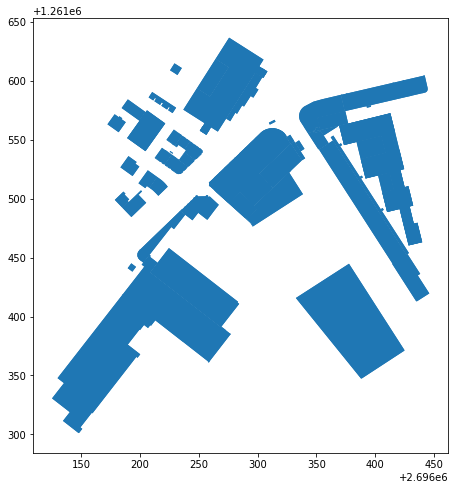

In [68]:
subs = gpd.read_file(r'K:\Geodaten\WinLab\220408_Datenlieferung_zhaw\211102_Datenlieferung_geonet\building_block_best_zukunft_singleparts_subset.shp')
subs.plot()

<hr>

do next file now

,FID_1,ART_ID,ART_NAME,ART_GRUPPE,GEBNR,JOB_VERSIO,EGID,Baujahr,AnzStock,Hoehe,Bemerkung,geometry
0,10768977,10,Nebengebäude,Gebäud,35701,5477642,210292699,2019,0,3.0,None,"POLYGON ((2694577.515 1263381.794, 2694576.338..."
1,11955440,10,Nebengebäude,Gebäud,36251,5539782,191950589,2020,0,3.0,None,"POLYGON ((2699609.030 1261001.347, 2699611.488..."
2,9823380,4,Wohngebäude,Gebäud,32740,5332482,210207682,2018,3,10.0,None,"POLYGON ((2700683.451 1258836.012, 2700682.312..."
3,9819938,4,Wohngebäude,Gebäud,32809,5412882,210207775,2018,5,16.0,None,"POLYGON ((2699991.929 1262258.598, 2699998.646..."
4,9677137,4,Wohngebäude,Gebäud,34352,5379100,210216465,2018,4,13.0,None,"POLYGON ((2697761.097 1262183.542, 2697764.209..."
...,...,...,...,...,...,...,...,...,...,...,...,...
608,8779680,4,Wohngebäude,Gebäud,33052,5237287,210212076,2017,2,7.0,None,"POLYGON ((2693493.103 1262629.134, 2693490.026..."
609,10907232,10,Nebengebäude,Gebäud,35646,5514670,210265553,2019,0,3.0,None,"POLYGON ((2700181.557 1262135.639, 2700183.396..."
610,9754557,10,Nebengebäude,Gebäud,34830,5390627,210220987,2019,0,3.0,None,"POLYGON ((2695508.829 1263049.318, 2695507.287..."
611,11936741,4,Wohngebäude,Gebäud,34953,5530844,210220660,2020,4,12.0,RE,"POLYGON ((2696190.017 1262247.372, 2696188.254..."


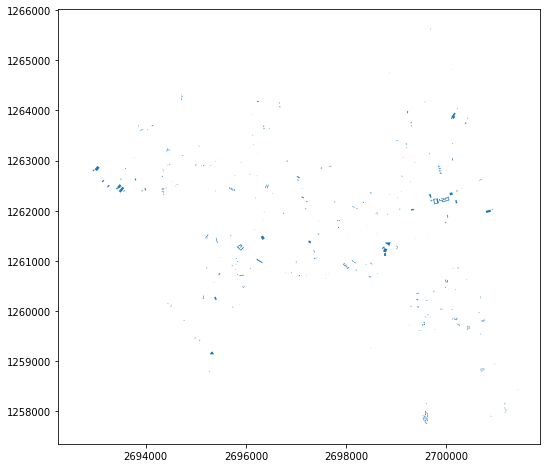

In [117]:
plt.rcParams["figure.figsize"] = (12,8)

agn3.plot()
agn3

In [118]:
agn3['HEIGHT_TOP'] = agn3.Hoehe
agn3['HEIGHT_BOT'] = 0
agn3['ID'] = agn3.index
agn3['BLDGTYP'] = 999

In [119]:
agn3 = classify_bldgtyp(agn3, name_jahrcol="Baujahr", name_typecol="ART_NAME", name_wohngebaeude='Wohngebäude')

In [120]:
agn3

,FID_1,ART_ID,ART_NAME,ART_GRUPPE,GEBNR,JOB_VERSIO,EGID,Baujahr,AnzStock,Hoehe,Bemerkung,geometry,HEIGHT_TOP,HEIGHT_BOT,ID,BLDGTYP
0,10768977,10,Nebengebäude,Gebäud,35701,5477642,210292699,2019,0,3.0,None,"POLYGON ((2694577.515 1263381.794, 2694576.338...",3.0,0,0,6
1,11955440,10,Nebengebäude,Gebäud,36251,5539782,191950589,2020,0,3.0,None,"POLYGON ((2699609.030 1261001.347, 2699611.488...",3.0,0,1,6
2,9823380,4,Wohngebäude,Gebäud,32740,5332482,210207682,2018,3,10.0,None,"POLYGON ((2700683.451 1258836.012, 2700682.312...",10.0,0,2,3
3,9819938,4,Wohngebäude,Gebäud,32809,5412882,210207775,2018,5,16.0,None,"POLYGON ((2699991.929 1262258.598, 2699998.646...",16.0,0,3,3
4,9677137,4,Wohngebäude,Gebäud,34352,5379100,210216465,2018,4,13.0,None,"POLYGON ((2697761.097 1262183.542, 2697764.209...",13.0,0,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,8779680,4,Wohngebäude,Gebäud,33052,5237287,210212076,2017,2,7.0,None,"POLYGON ((2693493.103 1262629.134, 2693490.026...",7.0,0,608,3
609,10907232,10,Nebengebäude,Gebäud,35646,5514670,210265553,2019,0,3.0,None,"POLYGON ((2700181.557 1262135.639, 2700183.396...",3.0,0,609,6
610,9754557,10,Nebengebäude,Gebäud,34830,5390627,210220987,2019,0,3.0,None,"POLYGON ((2695508.829 1263049.318, 2695507.287...",3.0,0,610,6
611,11936741,4,Wohngebäude,Gebäud,34953,5530844,210220660,2020,4,12.0,RE,"POLYGON ((2696190.017 1262247.372, 2696188.254...",12.0,0,611,3


<hr>

do next file now

Index(['fi', 'are', 'jah', 'gebaeudeh', 'dat_3d_na', 'name_baut', 'status_ba',
       'dat_vor_b', 'geometry'],
      dtype='object')

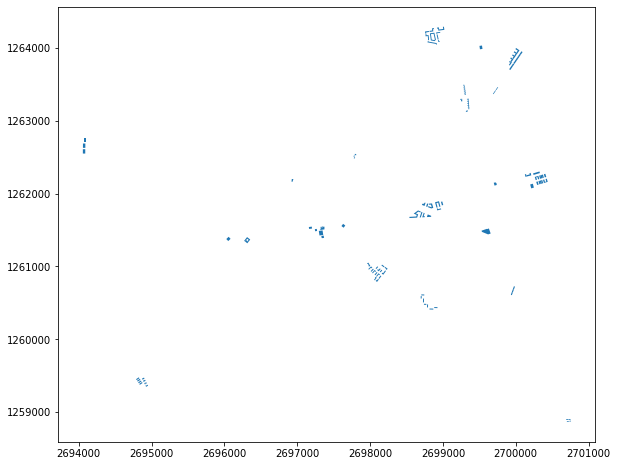

In [121]:
rpg.plot()
rpg.columns

In [122]:
rpg['HEIGHT_TOP'] = rpg.gebaeudeh
rpg['HEIGHT_BOT'] = 0
rpg['ID'] = rpg.index
rpg['BLDGTYP'] = 6

In [123]:
rpg.name_baut.unique()

array(['Gestaltungsplan Ohrbühlstrasse, Etappe 1',
       'Grüze / Häuser-Etappe 1', 'Areal Binzhof Masterplan Etappe 1',
       'Schulhaus Wallrüti (2. Etappe) – Ersatzneubau Turnhallentrakt/Singsaa',
       'Wässerwiesen Teil 3 (Gewerbe)', 'Hagmannareal Etappe 2',
       'Pappelwe', 'Rychenbergstrasse neben 101 (Cerfeda)',
       'Campus T_ZHAW, Etappe 2', 'GP Grabenacke',
       'Sulzerareal - Werk 1 - BF 4b-Rocke',
       'Keller-Areal Dättnau Etappe 3',
       'Tegerloo - Eichwaldhof, Etappe 1', 'Grüze / Hochhaus Evolu',
       'Talgut Teil HG', 'Talgut - Teil GWG (QEZ-Talgut)',
       'GP Am Bach Mitt', 'Lavendelwe',
       'Teil WGT «Talgut» Arch. Sik-Etappe 4', 'Campus T_ZHAW, Etappe 1',
       'Keller-Areal Dättnau Etappe 4',
       'Neuhegi Baufeld 3, Etappe 2 Gewerb', 'Neuhegi Baufeld 2, Hochhau',
       'Teil WGT «Talgut» Arch. Sik-Etappe 3',
       '"Chopf ab"-Brauerei / Doppelle', 'BFS',
       'Teil WGT «Talgut» Arch. Sik-Etappe 2', 'GP Schaffhauserstrass',
       'Neuhe

In [124]:
rpg

,fi,are,jah,gebaeudeh,dat_3d_na,name_baut,status_ba,dat_vor_b,geometry,HEIGHT_TOP,HEIGHT_BOT,ID,BLDGTYP
0,191001,None,2018,17.5,2021-09-20,"Gestaltungsplan Ohrbühlstrasse, Etappe 1",Entwicklungsphas,2027-12-31,"POLYGON ((2700398.869 1262223.044, 2700386.022...",17.5,0,0,6
1,191010,None,2018,3.0,None,Grüze / Häuser-Etappe 1,Entwicklungsphas,2027-12-31,"POLYGON ((2698744.116 1261734.263, 2698749.255...",3.0,0,1,6
2,191022,None,2018,12.0,2020-07-24,Areal Binzhof Masterplan Etappe 1,Entwicklungsphas,2027-12-31,"POLYGON ((2698789.721 1264176.072, 2698802.096...",12.0,0,2,6
3,191027,None,2018,13.0,2021-10-29,Schulhaus Wallrüti (2. Etappe) – Ersatzneubau ...,Entwicklungsphas,2029-12-31,"POLYGON ((2699522.407 1264031.719, 2699536.418...",13.0,0,3,6
4,191079,None,2018,13.5,2020-07-24,Wässerwiesen Teil 3 (Gewerbe),Entwicklungsphas,2026-12-31,"POLYGON ((2694068.617 1262610.004, 2694070.601...",13.5,0,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,197830,None,2020,16.8,2020-07-24,"Tegerloo - Eichwaldhof, Etappe 1",In Planun,2026-12-31,"POLYGON ((2700034.708 1263979.419, 2700051.755...",16.8,0,149,6
150,197832,None,2020,14.3,2020-07-24,"Tegerloo - Eichwaldhof, Etappe 1",In Planun,2026-12-31,"POLYGON ((2699996.521 1263923.793, 2699971.554...",14.3,0,150,6
151,197833,None,2020,16.8,2020-07-24,"Tegerloo - Eichwaldhof, Etappe 1",In Planun,2026-12-31,"POLYGON ((2699996.730 1263920.563, 2700012.083...",16.8,0,151,6
152,197841,None,2020,17.3,2020-07-24,"Tegerloo - Eichwaldhof, Etappe 1",In Planun,2026-12-31,"POLYGON ((2700052.227 1263916.739, 2700067.939...",17.3,0,152,6


<hr>

do next file now. drop unterirdische Gebäude

In [125]:
agp = agp.loc[agp.ART_NAME != 'unterirdisches Gebäude']

In [126]:
agp.ART_NAME.unique()

array(['Verwaltungsgebäude', 'Wohngebäude',
       'Land-, Forstwirtschaftsgebäud', 'Verkehrsgebäude',
       'Handelsgebäude', 'Industriegebäude', 'Gastgewerbegebäude',
       'Nebengebäude', 'Unterstand, Überdachung'], dtype=object)

Index(['FID_1', 'ART_ID', 'ART_NAME', 'ART_GRUPPE', 'GEBNR', 'EGID', 'Baujahr',
       'AnzStock', 'Hoehe', 'Flaeche', 'Bemerkung', 'geometry', 'HEIGHT_TOP',
       'HEIGHT_BOT', 'ID', 'BLDGTYP'],
      dtype='object')

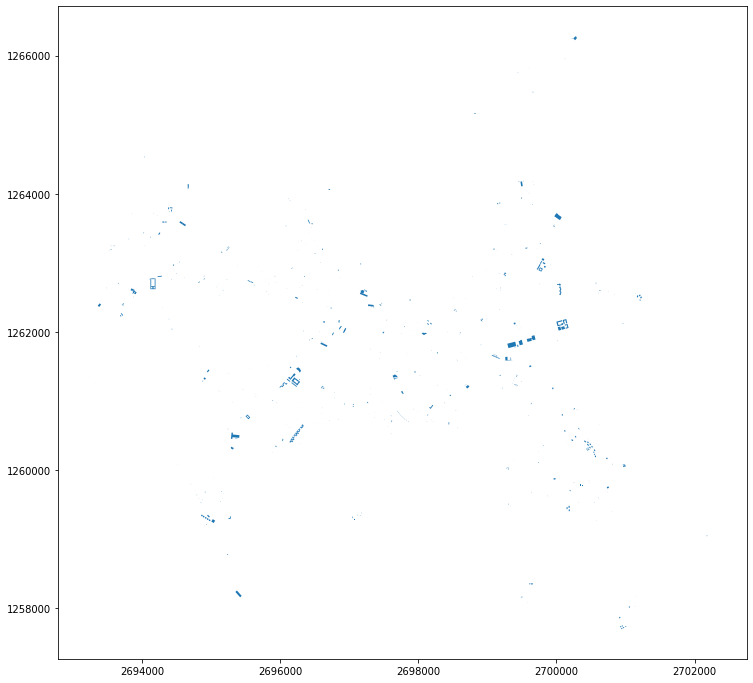

In [127]:
plt.rcParams["figure.figsize"] = (16,12)

agp.plot()
agp.columns

In [128]:
agp['HEIGHT_TOP'] = agp.Hoehe
agp['HEIGHT_BOT'] = 0
agp['ID'] = agp.index
agp['BLDGTYP'] = 999

In [129]:
agp.ART_NAME.unique()

array(['Verwaltungsgebäude', 'Wohngebäude',
       'Land-, Forstwirtschaftsgebäud', 'Verkehrsgebäude',
       'Handelsgebäude', 'Industriegebäude', 'Gastgewerbegebäude',
       'Nebengebäude', 'Unterstand, Überdachung'], dtype=object)

In [130]:
agp = classify_bldgtyp(agp, name_jahrcol='Baujahr', name_typecol='ART_NAME', name_wohngebaeude='Wohngebäude')

In [131]:
agp.loc[(agp.Baujahr == 0) & (agp.ART_NAME == 'Wohngebäude'), 'BLDGTYP'] = 3

agp.loc[(agp.Baujahr == 0) & (agp.ART_NAME != 'Wohngebäude'), 'BLDGTYP'] = 6

In [132]:
agp

,FID_1,ART_ID,ART_NAME,ART_GRUPPE,GEBNR,EGID,Baujahr,AnzStock,Hoehe,Flaeche,Bemerkung,geometry,HEIGHT_TOP,HEIGHT_BOT,ID,BLDGTYP
0,3466522,3,Verwaltungsgebäude,proj. Gebäude,23482,201010138,1958,0,0.0,2.13,nicht relevant,"POLYGON ((2697190.654 1262639.581, 2697191.530...",0.0,0,0,5
1,3466520,3,Verwaltungsgebäude,proj. Gebäude,23482,201010138,1958,0,34.0,2067.62,RE gemäss ASW,"POLYGON ((2697173.095 1262605.963, 2697184.831...",34.0,0,1,5
2,10786204,3,Verwaltungsgebäude,proj. Gebäude,36019,210295156,0,0,17.0,1904.90,RE BauPro,"POLYGON ((2697272.752 1262378.636, 2697275.447...",17.0,0,2,6
3,10801811,3,Verwaltungsgebäude,proj. Gebäude,485,1161926,1846,3,10.0,89.39,None,"POLYGON ((2697686.439 1261429.790, 2697692.410...",10.0,0,3,4
4,11981914,3,Verwaltungsgebäude,proj. Gebäude,1123,1161876,1876,3,10.0,268.04,None,"POLYGON ((2697946.390 1261413.902, 2697942.618...",10.0,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,11955125,100012,"Unterstand, Überdachung",proj. Gebäude,24541,201022410,2002,2,7.0,23.61,None,"POLYGON ((2694857.372 1259540.750, 2694859.815...",7.0,0,734,6
735,11954916,100012,"Unterstand, Überdachung",proj. Gebäude,36249,0,0,0,3.0,40.64,None,"POLYGON ((2694495.882 1262848.763, 2694501.043...",3.0,0,735,6
736,11954296,100012,"Unterstand, Überdachung",proj. Gebäude,36248,0,0,0,3.0,124.28,None,"POLYGON ((2698129.319 1260795.138, 2698138.922...",3.0,0,736,6
737,11954248,100012,"Unterstand, Überdachung",proj. Gebäude,36245,0,0,0,3.0,25.00,None,"POLYGON ((2700294.546 1260873.798, 2700298.892...",3.0,0,737,6


In [133]:
bbbz.to_file(outpath+r'\buildings\buildings_bbbz.shp')

In [72]:
rpg.to_file(outpath+r'\buildings\buildings_rpg.shp')

In [106]:
agp.to_file(outpath+r'\buildings\buildings_agp.shp')

In [72]:
agn3.to_file(outpath+r'\buildings\buildings_agn3.shp')

In [137]:
agn3.columns

Index(['FID_1', 'ART_ID', 'ART_NAME', 'ART_GRUPPE', 'GEBNR', 'JOB_VERSIO',
       'EGID', 'Baujahr', 'AnzStock', 'Hoehe', 'Bemerkung', 'geometry',
       'HEIGHT_TOP', 'HEIGHT_BOT', 'ID', 'BLDGTYP'],
      dtype='object')

In [147]:
rpg_s = rpg[['HEIGHT_TOP','HEIGHT_BOT','ID','BLDGTYP','geometry']]
agp_s = agp[['HEIGHT_TOP','HEIGHT_BOT','ID','BLDGTYP','geometry']]
agn3_s = agn3[['HEIGHT_TOP','HEIGHT_BOT','ID','BLDGTYP','geometry']]
bldg_outer_s = bldg_outer[['HEIGHT_TOP','HEIGHT_BOT','ID','BLDGTYP','geometry']]

In [152]:
import pandas as pd
bldglist = [bbbz, agn3_s, rpg_s, agp_s, bldg_outer_s]
bldg_tot = pd.concat(bldglist, ignore_index=True)
bldg_tot['ID'] = bldg_tot.index

In [145]:
%matplotlib qt
bldg_tot.plot()

In [153]:
bldg_tot.to_file(outpath+r'\buildings\buildings_merge.shp')